In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from cascadenet_pytorch.model_pytorch import *
from cascadenet_pytorch.dnn_io import to_tensor_format
from cascadenet_pytorch.dnn_io import from_tensor_format

from os.path import join
from scipy.io import loadmat
from utils import compressed_sensing as cs
from utils.metric import complex_psnr


In [2]:
import cv2
# 中值滤波去除横线
def median_filter_remove_lines(image_path, kernel_size=3):
    image = cv2.imread(image_path, 0)
    filtered_image = cv2.medianBlur(image, kernel_size)
    return filtered_image

# 形态学开运算去除横线
def morphology_open_remove_lines(image_path, kernel_size=(1, 5)):
    image = cv2.imread(image_path, 0)
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening

# 基于样本的图像修复（简单示例，需根据实际情况设置掩码）
def inpaint_remove_lines(image_path):
    image = cv2.imread(image_path, 0)
    mask = np.zeros_like(image)
    # 假设横线在图像的中间部分，这里简单设置掩码，实际需根据横线位置准确设置
    mask[image.shape[0]//2 - 10:image.shape[0]//2 + 10, :] = 1
    repaired_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
    return repaired_image

# 测试函数
def test_remove_lines():
    image_path = '/nfs/zzy/code/Deep-MRI-Reconstruction/models/crnn_mri_0109/004.png'
    median_filtered = median_filter_remove_lines(image_path)
    cv2.imwrite('median_filtered.png', median_filtered)

    morphology_opened = morphology_open_remove_lines(image_path)
    cv2.imwrite('morphology_opened.png', morphology_opened)

    inpainted = inpaint_remove_lines(image_path)
    cv2.imwrite('inpainted.png', inpainted)
    
test_remove_lines()


In [2]:
def prep_input(im, acc=4.0):
    """Undersample the batch, then reformat them into what the network accepts.

    Parameters
    ----------
    gauss_ivar: float - controls the undersampling rate.
                        higher the value, more undersampling
    """
    mask = cs.cartesian_mask(im.shape, acc, sample_n=8)  # 生成掩模
    im_und, k_und = cs.undersample(im, mask, centred=False, norm='ortho')  # 下采样
    im_gnd_l = torch.from_numpy(to_tensor_format(im))  # 转换为张量
    im_und_l = torch.from_numpy(to_tensor_format(im_und))  # 转换为张量
    k_und_l = torch.from_numpy(to_tensor_format(k_und))  # 转换为张量
    mask_l = torch.from_numpy(to_tensor_format(mask, mask=True))  # 转换为张量

    return im_und_l, k_und_l, mask_l, im_gnd_l

def create_dummy_data():
    """Create small cardiac data based on patches for demo.

    Note that in practice, at test time the method will need to be applied to
    the whole volume. In addition, one would need more data to prevent
    overfitting.

    """
    project_root = '.'
    data = loadmat(join(project_root, './data/cardiac.mat'))['seq']
    nx, ny, nt = data.shape
    ny_red = 8
    sl = ny//ny_red
    data_t = np.transpose(data, (2, 0, 1))
    
    # Synthesize data by extracting patches
    train = np.array([data_t[..., i:i+sl] for i in np.random.randint(0, sl*3, 20)])
    validate = np.array([data_t[..., i:i+sl] for i in (sl*4, sl*5)])
    test = np.array([data_t[..., i:i+sl] for i in (sl*6, sl*7)])

    return train, validate, test

In [54]:
# 假设模型已保存，加载模型
# model_path = '/nfs/zzy/code/Deep-MRI-Reconstruction/models/crnn_mri/crnn_mri_epoch_19.npz'  # 替换为您保存的模型路径
# model_path = '/nfs/zzy/code/Deep-MRI-Reconstruction/models/pretrained/crnn_mri_d5_c5.pth'  # 替换为您保存的模型路径
# model_path = '/nfs/zzy/code/Deep-MRI-Reconstruction/models/crnn_mri/crnn_mri_epoch_99.npz'
model_path = '/nfs/zzy/code/Deep-MRI-Reconstruction/models/crnn_mri/crnn_mri_epoch_799.npz'
rec_net = CRNN_MRI()
rec_net.load_state_dict(torch.load(model_path))

# 如果有CUDA支持，使用CUDA
cuda = torch.cuda.is_available()
if cuda:
    rec_net.cuda()

train, validate, test = create_dummy_data()  # 使用 create_dummy_data() 生成数据
# test_data = test  # 选择 test 数据作为测试集
test_data = test  # 选择 test 数据作为测试集


# 加载测试数据集并生成相应的输入数据
im_und, k_und, mask, im_gnd = prep_input(test_data, acc=4.0)  # 使用合适的测试数据


/tmp/ipykernel_199397/2937445655.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rec_net.load_state_dict(torch.load(model_path))


In [55]:
# # 使用模型进行预测
# with torch.no_grad():
#     im_u = torch.tensor(im_und, dtype=torch.float32).cuda() if cuda else torch.tensor(im_und, dtype=torch.float32)
#     k_u = torch.tensor(k_und, dtype=torch.float32).cuda() if cuda else torch.tensor(k_und, dtype=torch.float32)
#     mask = torch.tensor(mask, dtype=torch.float32).cuda() if cuda else torch.tensor(mask, dtype=torch.float32)
#     gnd = torch.tensor(im_gnd, dtype=torch.float32).cuda() if cuda else torch.tensor(im_gnd, dtype=torch.float32)
    
#     pred = rec_net(im_u, k_u, mask, test=True)

# 使用模型进行预测
with torch.no_grad():
    im_u = im_und.clone().detach().float().cuda() if cuda else im_und.clone().detach().float()
    k_u = k_und.clone().detach().float().cuda() if cuda else k_und.clone().detach().float()
    mask = mask.clone().detach().float().cuda() if cuda else mask.clone().detach().float()
    gnd = im_gnd.clone().detach().float().cuda() if cuda else im_gnd.clone().detach().float()
    
    pred = rec_net(im_u, k_u, mask, test=True)



CRNN_MRI-forward-x: torch.float32
CRNN_MRI-forward-x: torch.Size([2, 2, 256, 32, 30])
CRNN_MRI-forward-k: torch.Size([2, 2, 256, 32, 30])
CRNN_MRI-forward-m: torch.Size([2, 2, 256, 32, 30])
BCRNNlayer-forward-input: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.float32
CRNNcell-hidden_iteration: torch.float32
CRNNcell-input: torch.float32
CRNNcell-hidden: torch.flo

im_gnd_np-dtype: float32
pred_np-dtype: float32
mask_np-dtype: float32


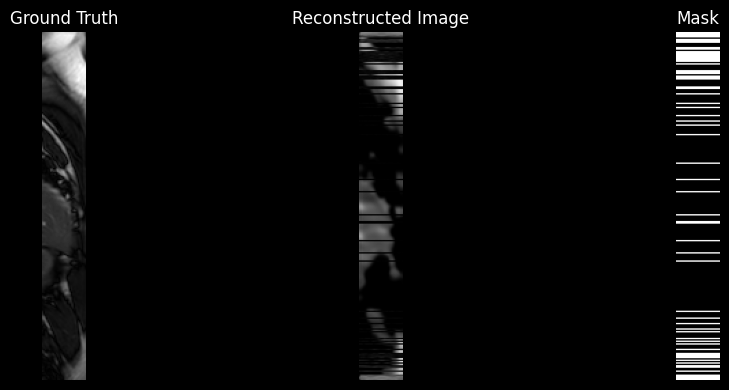

In [56]:
# 从 tensor 格式转换为 NumPy 格式
# im_gnd_np = from_tensor_format(im_gnd.numpy())[0]  # 获取原始图像
# pred_np = from_tensor_format(pred.cpu().numpy())[0]  # 获取重建图像
# 对原始图像数据取模
im_gnd_np = np.abs(from_tensor_format(im_gnd.numpy())[0])
# 假设30是时间序列维度，选取第0时刻的图像数据（维度变为(256, 32)符合要求）
im_gnd_np = im_gnd_np[0]
# 对重建图像数据取模
pred_np = np.abs(from_tensor_format(pred.cpu().numpy())[0])
# 假设30是时间序列维度，选取第0时刻的图像数据（维度变为(256, 32)符合要求）
pred_np = pred_np[0]
mask_np = from_tensor_format(mask.cpu().numpy(), mask=True)[0]  # 获取掩模图像
mask_np = mask_np[0]
# im_gnd_np-dtype: complex64
# pred_np-dtype: complex64
# mask_np-dtype: float32
print('im_gnd_np-dtype:',im_gnd_np.dtype)
print('pred_np-dtype:',pred_np.dtype)
print('mask_np-dtype:',mask_np.dtype)


# 绘制原始图像、重建图像和掩模
plt.figure(figsize=(12, 4))

# 显示原始图像
plt.subplot(1, 3, 1)
plt.imshow(im_gnd_np, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# 显示重建图像
plt.subplot(1, 3, 2)
plt.imshow(pred_np, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

# 显示掩模图像
plt.subplot(1, 3, 3)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# 保存图像（可选）
plt.imsave("output/rcnn/ground_truth_99.png", im_gnd_np, cmap='gray')
plt.imsave("output/rcnn/reconstructed_image_99.png", pred_np, cmap='gray')
plt.imsave("output/rcnn/mask_99.png", mask_np, cmap='gray')

In [45]:
# 保存图像（可选）
plt.imsave("output/rcnn/ground_truth_399.png", im_gnd_np, cmap='gray')
plt.imsave("output/rcnn/reconstructed_image_399.png", pred_np, cmap='gray')
plt.imsave("output/rcnn/mask_399.png", mask_np, cmap='gray')

In [57]:
import torch


def c2r(kspace):
    """
    将复数形式的kspace张量转换为五维实数形式张量，新增第二个维度（大小为2）来分别表示实部和虚部。

    参数:
    kspace (torch.Tensor): 复数形式的张量，形状为 (batch_size, time_steps, height, width)，数据类型为torch.complex64等复数类型

    返回:
    torch.Tensor: 转换后的实数形式张量，形状为 (batch_size, 2, time_steps, height, width)，数据类型为torch.float32
    """
    # 使用torch.view_as_real将复数张量转换为实部和虚部的表示形式
    # 结果的形状变为 (batch_size, time_steps, 2, height, width)，其中最后一个维度的2表示实部和虚部
    kspace_real_imag = torch.view_as_real(kspace)

    # 调整维度顺序，将表示实部和虚部的维度放到第二个维度，保持batch_size等其他维度顺序
    # 转换后的形状变为 (batch_size, 2, time_steps, height, width)
    kspace_real_imag = kspace_real_imag.permute(0, 2, 1, 3, 4)

    return kspace_real_imag


# 以下是模拟使用上述函数的示例代码（你可以根据实际情况替换真实数据）
# 假设我们有一个形状为 (4, 18, 192, 192) 的复数张量，这里随机生成一个类似形状和类型的张量来模拟
simulated_kspace = torch.randn(4, 18, 192, 192, dtype=torch.complex64)

# 调用函数进行转换
kspace_real = c2r(simulated_kspace)
# train_one_epoch-kspace_real torch.Size([4, 192, 18, 192, 2])
# train_one_epoch-kspace_real-dtype: torch.float32
print('train_one_epoch-kspace_real', kspace_real.shape)
print('train_one_epoch-kspace_real-dtype:', kspace_real.dtype)

train_one_epoch-kspace_real torch.Size([4, 192, 18, 192, 2])
train_one_epoch-kspace_real-dtype: torch.float32
